# Machine-Learning test

- `xgboost`, `lightgbm`あたりの手法を`sklearn`のpipeline, gridsearchCVと組み合わせて使えるようにする（目標）


---

### sklearn
- https://qiita.com/R0w0/items/3b3d8e660b8abc1f804d
- https://qiita.com/ishizakiiii/items/0650723cc2b4eef2c1cf
- https://qiita.com/yhyhyhjp/items/c81f7cea72a44a7bfd3a
- https://qiita.com/saiaron/items/bb96c0f898cd0cbcd788
- https://qiita.com/issakuss/items/d30303e200756980ae45


### xgboost
- http://wolfin.hatenablog.com/entry/2018/02/08/092124
- http://tekenuko.hatenablog.com/entry/2016/09/22/220814
- https://qiita.com/katsu1110/items/a1c3185fec39e5629bcb
- https://blog.amedama.jp/entry/2019/01/29/235642
- https://qiita.com/aaatsushi_bb/items/0b605c0f27493f005c88
- http://smrmkt.hatenablog.jp/entry/2015/04/28/210039
- https://qiita.com/msrks/items/e3e958c04a5167575c41
- https://yag.xyz/blog/2015/08/08/xgboost-python/
- http://wolfin.hatenablog.com/entry/2018/02/08/092124

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [3]:
import xgboost as xgb
import lightgbm as lgb

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer

In [5]:
import umap

In [32]:
import matplotlib.pyplot as plt

- mpgのテストデータを使ってみる

In [6]:
df_mpg = spark.read.load("/home/jovyan/work/hive-db/external/tf_testdata/mpg", format="orc")
df_mpg.show()
pdf_mpg = df_mpg.toPandas()

+----+---------+------------+----------+------+------------+----------+------+
| MPG|Cylinders|Displacement|Horsepower|Weight|Acceleration|Model_Year|Origin|
+----+---------+------------+----------+------+------------+----------+------+
|18.0|        6|       250.0|      78.0|3574.0|        21.0|        76|     1|
|18.5|        6|       250.0|     110.0|3645.0|        16.2|        76|     1|
|17.5|        6|       258.0|      95.0|3193.0|        17.8|        76|     1|
|29.5|        4|        97.0|      71.0|1825.0|        12.2|        76|     2|
|32.0|        4|        85.0|      70.0|1990.0|        17.0|        76|     3|
|28.0|        4|        97.0|      75.0|2155.0|        16.4|        76|     3|
|26.5|        4|       140.0|      72.0|2565.0|        13.6|        76|     1|
|20.0|        4|       130.0|     102.0|3150.0|        15.7|        76|     2|
|13.0|        8|       318.0|     150.0|3940.0|        13.2|        76|     1|
|19.0|        4|       120.0|      88.0|3270.0|     

- make data

In [7]:
pdf_mpg_oneHot = pd.get_dummies(pdf_mpg, columns=['Origin'], drop_first=False)

In [8]:
y = pdf_mpg_oneHot.MPG.values
X = pdf_mpg_oneHot.drop(columns=["MPG"]).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

- imputerを使うのはPipelineのテスト用で実質的な意味は無い

In [114]:
%%time

eval_results = {}

# pipeline
pl_xgb = Pipeline([
    ("IMP", SimpleImputer(fill_value=-99999)),
    ("XGB", xgb.XGBRegressor(#early_stopping_rounds=20,
                             objective="reg:squarederror",
                             #eval_metric="rmse",
                             n_estimators=1000,
                             callbacks=[xgb.callback.record_evaluation(eval_result=eval_results),],  # うまく働いていない様子?
                             #verbosity=0,  # silent
                             #silent=True,
                             random_state=0))
])

# GridSearch用パラメータ（仮） 要ブラッシュアップ
param_grid = {  # 手法の確認が大事で、実際にサーチするのはとりあえず良いので適当に省く
    'XGB__learning_rate': [0.05, 0.1,], 
    'XGB__max_depth': [3, 5, 7, 9], 
    'XGB__subsample': [0.8, 0.9, 1.0], 
    'XGB__colsample_bytree': [0.7, 0.8, 0.9],
}
fit_params = {
    "XGB__eval_set": [(X_train, y_train), (X_test, y_test)],
    "XGB__eval_metric": ["rmse","mae"],
    "XGB__verbose": 0,
    "XGB__early_stopping_rounds": 20,
}

grid_search = GridSearchCV(estimator=pl_xgb,
                           param_grid=param_grid,
                           scoring="r2",
                           cv=3,
                           verbose=0,
                          )

grid_search.fit(X_train, y_train, **fit_params)

CPU times: user 7.45 s, sys: 0 ns, total: 7.45 s
Wall time: 7.45 s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('IMP',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=-99999,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('XGB',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     callbacks=[<function record_evaluation.<locals>.callback at 0x7f7c7b58d7a0>],
                                                     colsample_bylevel=1,
                                                     co

In [11]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [115]:
display(grid_search.best_params_)
display(grid_search.best_score_)
display(grid_search.best_estimator_)

{'XGB__colsample_bytree': 0.7,
 'XGB__learning_rate': 0.1,
 'XGB__max_depth': 3,
 'XGB__subsample': 0.9}

0.8631206958764026

Pipeline(memory=None,
         steps=[('IMP',
                 SimpleImputer(add_indicator=False, copy=True,
                               fill_value=-99999, missing_values=nan,
                               strategy='mean', verbose=0)),
                ('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              callbacks=[<function record_evaluation.<locals>.callback at 0x7f7c7b58d7a0>],
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=1000, n_jobs=1,
                              nthread=None, objective='reg:squarederror',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=Non

In [116]:
r2_score(y_pred=grid_search.predict(X_test), y_true=y_test)

0.8572008411728247

In [117]:
learning_data = grid_search.best_estimator_.steps[1][1].evals_result()

In [118]:
df_learning = pd.DataFrame({
    "train_rmse": learning_data['validation_0']["rmse"],
    "test_rmse": learning_data["validation_1"]["rmse"],
    "train_mae": learning_data["validation_0"]["mae"],
    "test_mae": learning_data["validation_1"]["mae"]
})
display(df_learning[-5:])


,train_rmse,test_rmse,train_mae,test_mae
89,1.499759,2.641740,1.146058,1.983818
90,1.498293,2.642846,1.143369,1.983930
91,1.494015,2.642723,1.139090,1.981046
92,1.487174,2.646271,1.135026,1.983752
93,1.479439,2.638267,1.129386,1.980774


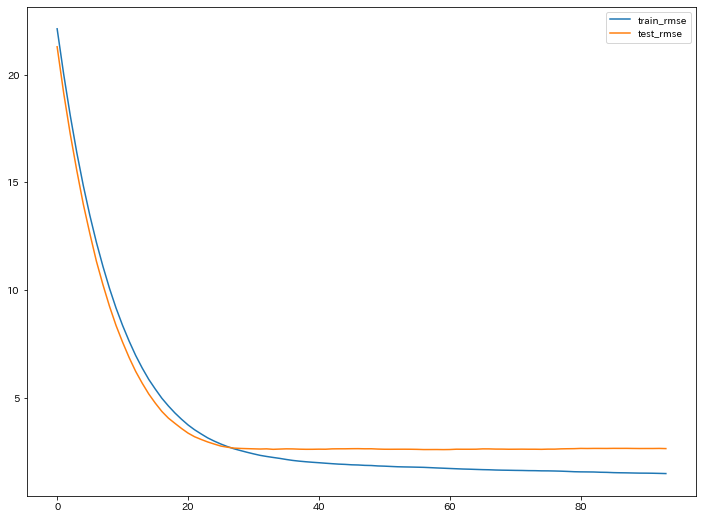

In [119]:
_, ax = plt.subplots(figsize=(12, 9))

df_learning[["train_rmse", "test_rmse"]].plot(ax=ax)
plt.show()

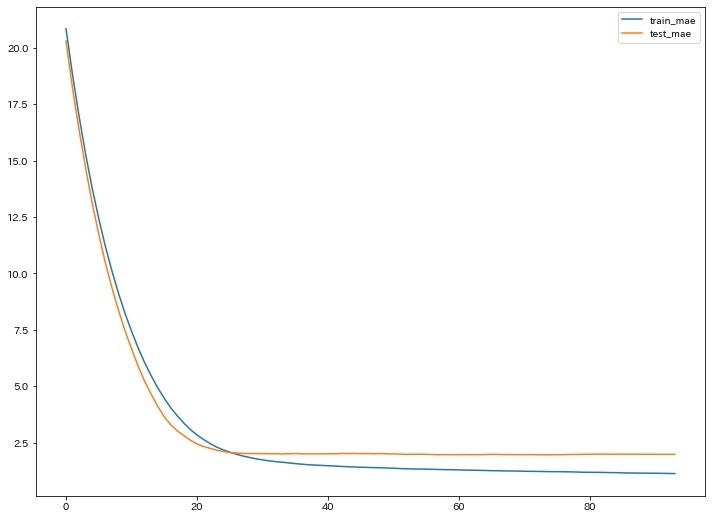

In [120]:
_, ax = plt.subplots(figsize=(12, 9))

df_learning[["train_mae", "test_mae"]].plot(ax=ax)
plt.show()

In [121]:
feature_importtance = grid_search.best_estimator_.steps[1][1].feature_importances_
display(feature_importtance)

array([0.05165613, 0.40347216, 0.1183825 , 0.21913567, 0.01677631,
       0.11591727, 0.0394848 , 0.01569174, 0.01948338], dtype=float32)

In [84]:
eval_results2={}
model_xgb = xgb.XGBRegressor(#early_stopping_rounds=10,
                             objective="reg:squarederror",
                             n_estimators=1000,
                             callbacks=[xgb.callback.record_evaluation(eval_result=eval_results2),],
                             random_state=0,
                             #silent=True,
                            )

In [85]:
model_xgb.fit(
    X_train, y_train, eval_metric=["rmse","mae"],   
    early_stopping_rounds=20,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=0
             )

XGBRegressor(base_score=0.5, booster='gbtree',
             callbacks=[<function record_evaluation.<locals>.callback at 0x7f7c79ef8830>],
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [102]:
eval_result2 = model_xgb.evals_result()

df_evals2 = pd.DataFrame({
    "train_rmse": eval_result2["validation_0"]["rmse"],
    "train_mae": eval_result2["validation_0"]["mae"],
    "test_rmse": eval_result2["validation_1"]["rmse"],
    "test_mae": eval_result2["validation_1"]["mae"]
})
df_evals2[-5:]

,train_rmse,train_mae,test_rmse,test_mae
47,1.823304,1.346833,2.661465,2.031392
48,1.809409,1.340060,2.667198,2.035068
49,1.794926,1.330759,2.671304,2.036406
50,1.785801,1.323275,2.671929,2.036625
51,1.775736,1.318270,2.676368,2.039552


In [87]:
r2_score(y_pred=model_xgb.predict(X_test), y_true=y_test)

0.8443040566756019

In [88]:
model_xgb.feature_importances_

array([0.01197179, 0.4588093 , 0.11465207, 0.2972325 , 0.01463368,
       0.07777458, 0.02163796, 0.00328813, 0.        ], dtype=float32)

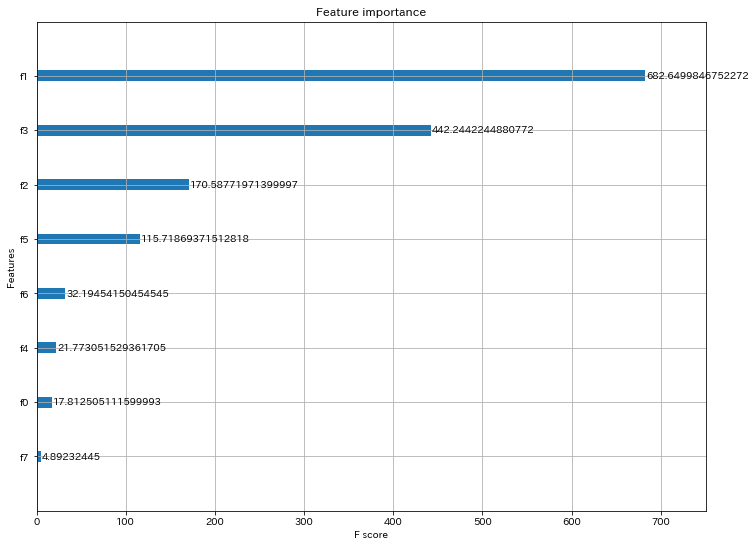

In [89]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(12,9))

xgb.plot_importance(model_xgb,
                   ax=ax,
                   importance_type="gain",
                   show_values=True)
plt.show()

In [90]:
model_xgb.feature_importances_

array([0.01197179, 0.4588093 , 0.11465207, 0.2972325 , 0.01463368,
       0.07777458, 0.02163796, 0.00328813, 0.        ], dtype=float32)

- callbacksの使い方がうまく出来ていないが、これでも最低限のことは出来ていそう

In [91]:
len(df_evals2)

52